# Research

In [45]:
import pandas as pd
from datetime import datetime, timedelta, date
import time
import ray
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import yfinance as yf


In [46]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates = exchange_rates.sort_index()
exchange_rates

Date
2020-05-04    0.91706
2020-05-05    0.92247
2020-05-06    0.92611
2020-05-07    0.92288
2020-05-08    0.91174
               ...   
2024-07-09    0.92470
2024-07-10    0.92311
2024-07-11    0.92031
2024-07-12    0.91571
2024-07-13    0.91570
Name: USD2EUR, Length: 1532, dtype: float64

# Research All ETFs

In [5]:
@ray.remote
def etf_history(etf) -> pd.Series:
    symbol = etf.Symbol
    if etf.Exchange == "XPAR":
        symbol += ".PA"
    elif etf.Exchange == "XETR":
        symbol += ".DE"
    elif etf.Exchange == "XLON":
        symbol += ".L"
    elif etf.Exchange == "XAMS":
        symbol += ".AS"
    try:
        ds = yf.Ticker(symbol).history(period="6mo")['Close']
        ds.index = ds.index.date
        ds = ds.sort_index()
    except Exception:
        return None
    if etf.Currency == "USD":
        max_date = min(ds.index.max(), exchange_rates.index.max())
        min_date = max(ds.index.min(), exchange_rates.index.min())
        ds = ds[min_date:max_date] * exchange_rates[min_date:max_date]
        ds = ds.dropna()
    ds.name = symbol
    return ds

In [6]:
# Get the list of tradable ETFs in BEST. Each row contains Exchange, Symbol, Currency
etfs = pd.read_csv("etf.csv")

# get the 6 month quotes
data = [x for x in ray.get([etf_history.remote(etf) for etf in etfs.itertuples()]) if x is not None]

data

TPAL.L: No data found, symbol may be delisted
HRUD.L: No price data found, symbol may be delisted (period=6mo)
OD7U.DE: No data found, symbol may be delisted
OD7A.DE: No data found, symbol may be delisted
OD7C.DE: No data found, symbol may be delisted
OD7D.DE: No data found, symbol may be delisted
OD7M.DE: No data found, symbol may be delisted
VZLA.DE: No data found, symbol may be delisted
XPPT.DE: No data found, symbol may be delisted
XGDU.DE: No data found, symbol may be delisted
XGDE.DE: No data found, symbol may be delisted
XPPE.DE: No data found, symbol may be delisted
XSLE.DE: No data found, symbol may be delisted
XAD5.DE: No data found, symbol may be delisted
XAD1.DE: No data found, symbol may be delisted


,SIVR,AMLP,DIVO,IBUY,BLOK,COMO.PA,SHC.PA,BX4.PA,LVC.PA,CAC.PA,...,DXS3.DE,D5BM.DE,XDPE.DE,DX2Z.DE,DXSN.DE,XSX6.DE,XGSD.L,XSMI.DE,XDGU.DE,XUHY.DE
2024-01-16,20.176660,38.090343,32.723868,46.181112,24.791093,20.950001,10.588,0.8708,35.915001,72.930000,...,7.031,86.204002,63.068836,15.344000,11.819202,113.900002,2309.00,122.800003,11.9750,11.7760
2024-01-17,19.834085,37.706083,32.623929,45.933500,24.565236,20.728001,10.700,0.8890,35.189999,72.220001,...,7.108,85.848000,62.559589,15.214000,11.911475,112.680000,2268.50,121.360001,11.9595,11.7495
2024-01-18,20.017080,37.650988,32.724493,46.047560,24.200713,20.788000,10.586,0.8698,35.924999,73.050003,...,7.069,86.122002,62.910820,15.244000,11.824512,113.320000,2275.25,121.480003,11.9350,11.7485
2024-01-19,19.807596,37.401019,32.883927,46.440656,24.370122,20.643999,10.634,0.8776,35.605000,72.690002,...,7.006,86.667999,63.173588,15.298000,11.798437,113.019997,2281.00,120.559998,11.8755,11.6910
2024-01-22,19.425653,38.298884,33.051557,47.399330,24.463638,20.565001,10.566,0.8672,36.040001,73.080002,...,6.924,87.624001,64.105581,15.712000,11.745488,114.000000,2282.00,121.860001,11.9405,11.7625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-15,NaN,NaN,NaN,NaN,NaN,20.843000,10.564,0.8665,36.080002,73.059998,...,6.989,85.727997,62.714762,15.324000,11.703857,114.180000,2319.00,122.480003,11.9595,11.7460
2024-02-19,NaN,NaN,NaN,NaN,NaN,20.934000,10.134,0.7946,39.355000,76.610001,...,6.834,91.463997,66.754523,15.942000,11.640230,118.900002,2296.00,123.139999,11.8955,11.8895
2024-05-27,NaN,NaN,NaN,NaN,NaN,24.544001,9.668,0.7139,44.200001,81.739998,...,6.536,96.531998,70.075162,17.177999,10.712936,128.320007,NaN,125.459999,11.5200,11.4575
2024-06-19,NaN,NaN,NaN,NaN,NaN,23.851000,10.352,0.8147,38.520000,76.480003,...,6.425,100.955002,73.214387,17.062000,11.283365,126.540001,2345.00,131.940002,11.8335,11.6750


In [7]:
# Get the amount of Nulls in the historical quotes
df_nan = pd.DataFrame([[etf,df_quotes[etf].isnull().sum()] for etf in df_quotes.columns],columns=['symbol','nan_amount'])
print(df_nan.groupby('nan_amount').count().reset_index())

   nan_amount  symbol
0           2     442
1           3     112
2           6     282
3          29       1
4          32       1
5          75       1
6         115       1


In [8]:
# Ignore ETFs with more than 5 nulls
df_quotes = df_quotes[df_nan[df_nan['nan_amount']<=5]['symbol']].sort_index()
print(len(df_quotes.columns))

554


In [9]:
# Fill in NaN
df_quotes = df_quotes.ffill().bfill()

In [10]:
from pypfopt.expected_returns import mean_historical_return, ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
import cvxpy
import numpy as np
cvxpy.installed_solvers()

['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']

In [11]:
def valid_date(d: date) -> date:
    if d in df_quotes.index:
        return d
    return max(dd for dd in df_quotes.index if dd <= d)



### Parameters

In [12]:
risk_free_rate = 0.028
last_n = 58
span = 3
cov_n = 153

first_date = valid_date(df_quotes.index.max() - timedelta(days=last_n))

### Best Portofolio from all the funds

In [13]:
### Inputs
# Funds to use

mu = mean_historical_return(df_quotes.loc[first_date:])
S = CovarianceShrinkage(df_quotes).ledoit_wolf()
ef = EfficientFrontier(mu, S, solver='SCS',weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()
cleaned_weights = [(s,w) for s,w in cleaned_weights.items() if w > 0.0]
df = pd.DataFrame(cleaned_weights,columns=['symbol','w']).sort_values(by='w',ascending=False)
df


,symbol,w
269,QQQ3.L,0.05368
54,CHIP.PA,0.03172
62,LQQ.PA,0.02621
271,3USL.L,0.02257
240,VVSM.DE,0.01848
...,...,...
185,JREE.DE,0.00011
68,UCT2.DE,0.00011
128,TRGB.L,0.00011
277,DBXP.DE,0.00010


In [14]:
ef.portfolio_performance(verbose=True,risk_free_rate=risk_free_rate)

Expected annual return: 81.5%
Annual volatility: 57.2%
Sharpe Ratio: 1.38


(0.8151005162635083, 0.5716333099234937, 1.3769325590365828)

In [15]:
mu = mean_historical_return(df_quotes.loc[first_date:][df[df['w']>=0.005]['symbol']])
S = CovarianceShrinkage(df_quotes[df[df['w']>=0.005]['symbol']]).ledoit_wolf()
ef = EfficientFrontier(mu, S, solver='SCS',weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()
cleaned_weights = [(s,w) for s,w in cleaned_weights.items() if w > 0.0]
df = pd.DataFrame(cleaned_weights,columns=['symbol','w']).sort_values(by='w',ascending=False)
df

,symbol,w
2,BX4.PA,0.27719
8,UE24.AS,0.18766
0,QQQ3.L,0.16315
6,SBIO.AS,0.11274
3,CI2.PA,0.08934
5,SJP3.L,0.07371
4,JEDI.DE,0.04939
1,CHIP.PA,0.02993
9,3NGS.L,0.00953
7,JPHE.PA,0.00735


In [16]:
ef.portfolio_performance(verbose=True,risk_free_rate=risk_free_rate)

Expected annual return: 132.8%
Annual volatility: 10.5%
Sharpe Ratio: 12.42


(1.3284701819711917, 0.10467070707241379, 12.424394736069702)

<Axes: >

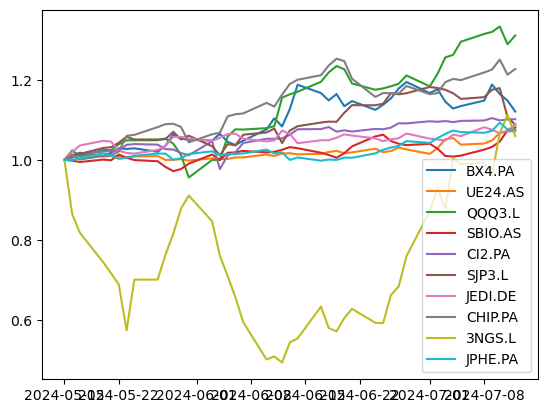

In [17]:
(df_quotes.loc[first_date:]/df_quotes.loc[first_date])[df['symbol']].plot()

In [18]:
### Inputs
# Funds to use

mu = ema_historical_return(df_quotes.loc[first_date:],span=9)
S = CovarianceShrinkage(df_quotes).ledoit_wolf()
ef = EfficientFrontier(mu, S, solver='SCS',weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()
cleaned_weights = [(s,w) for s,w in cleaned_weights.items() if w > 0.0]
df = pd.DataFrame(cleaned_weights,columns=['symbol','w']).sort_values(by='w',ascending=False)
df


,symbol,w
28,FAGB.L,0.51750
16,XRH0.L,0.36869
62,3NGS.L,0.33305
10,CHIP.PA,0.16041
52,VVSM.DE,0.13402
...,...,...
44,JREU.DE,0.00067
58,VEMT.AS,0.00052
5,GGOV.PA,0.00051
41,IUAE.L,0.00051


<Axes: >

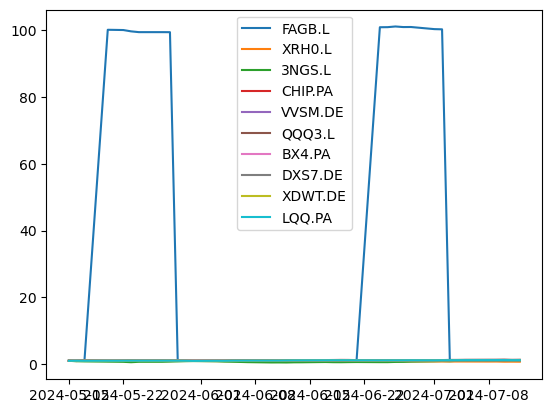

In [19]:
(df_quotes.loc[first_date:]/df_quotes.loc[first_date])[df[:10]['symbol']].plot()

In [20]:
ef.portfolio_performance(verbose=True,risk_free_rate=risk_free_rate)

Expected annual return: 92251530529679438387737010271647580148619496093792395642347192320000.0%
Annual volatility: 12385.5%
Sharpe Ratio: 7448349438676163407335900141257789361511285173339200738440511488.00


(9.225153052967944e+65, 123.85499806259871, 7.448349438676163e+63)

In [21]:
mu = ema_historical_return(df_quotes.loc[first_date:][df[df['w']>=0.01]['symbol']],span=9)
S = CovarianceShrinkage(df_quotes[df[df['w']>=0.01]['symbol']]).ledoit_wolf()
ef = EfficientFrontier(mu, S, solver='SCS',weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()
cleaned_weights = [(s,w) for s,w in cleaned_weights.items() if w > 0.0]
df = pd.DataFrame(cleaned_weights,columns=['symbol','w']).sort_values(by='w',ascending=False)
df

,symbol,w
0,FAGB.L,0.66836
1,XRH0.L,0.04272
2,3NGS.L,0.03972
3,CHIP.PA,0.01945
4,VVSM.DE,0.01656
5,QQQ3.L,0.01271
6,BX4.PA,0.01031
7,DXS7.DE,0.00992
8,XDWT.DE,0.00861
9,LQQ.PA,0.00850


In [22]:
ef.portfolio_performance(verbose=True,risk_free_rate=risk_free_rate)

Expected annual return: 119143343179178380611083409177199498149635882910255302023936296878080.0%
Annual volatility: 16003.4%
Sharpe Ratio: 7444864795275493418206888529140752351154726634665828873372958720.00


(1.1914334317917837e+66, 160.03426046741194, 7.444864795275493e+63)

In [23]:
### Inputs
# Funds to use
mu = ema_historical_return(df_quotes.loc[first_date:],span=9)
# mu = mean_historical_return(df_quotes.loc[first_date:])
S = CovarianceShrinkage(df_quotes).ledoit_wolf()
ef = EfficientFrontier(mu, S, solver='SCS',weight_bounds=(0,1))
ef.min_volatility()
cleaned_weights = ef.clean_weights()
cleaned_weights = [(s,w) for s,w in cleaned_weights.items() if w > 0.001]
df = pd.DataFrame(cleaned_weights,columns=['symbol','w']).sort_values(by='w',ascending=False)
df


,symbol,w
19,BXX.PA,0.00216
2,BX4.PA,0.00211
543,DXS3.DE,0.00204
18,BSX.PA,0.00203
504,DXSP.DE,0.00202
...,...,...
20,LVE.PA,0.00164
171,BCHN.L,0.00159
119,LQQ.PA,0.00159
499,3USL.L,0.00152


In [24]:
ef.portfolio_performance(verbose=True,risk_free_rate=risk_free_rate)

Expected annual return: 1005162809936240649640107506610439687297461859888628670398464.0%
Annual volatility: 24.0%
Sharpe Ratio: 41810863758121118684674429049713937572560293048194357526528.00


(1.0051628099362406e+58, 0.24040709030819846, 4.181086375812112e+58)

In [25]:
mu = ema_historical_return(df_quotes.loc[first_date:][df[:30]['symbol']],span=9)
S = CovarianceShrinkage(df_quotes[df[:30]['symbol']]).ledoit_wolf()
ef = EfficientFrontier(mu, S, solver='SCS',weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=risk_free_rate)
#ef.min_volatility()
cleaned_weights = ef.clean_weights()
cleaned_weights = [(s,w) for s,w in cleaned_weights.items() if w > 0.0]
df = pd.DataFrame(cleaned_weights,columns=['symbol','w']).sort_values(by='w',ascending=False)
df

,symbol,w
22,CNYB.AS,0.30225
7,3NGS.L,0.22701
21,AFLE.PA,0.16136
9,DSB.PA,0.15191
27,CBND.L,0.10789
19,JGSA.L,0.02950
23,IB01.L,0.00687
1,BX4.PA,0.00144
0,BXX.PA,0.00142
14,WEAT.L,0.00138


In [26]:
ef.portfolio_performance(verbose=True,risk_free_rate=risk_free_rate)

Expected annual return: 7751.1%
Annual volatility: 29.6%
Sharpe Ratio: 261.63


(77.51063318555745, 0.29615469600219035, 261.6289197216862)

<Axes: >

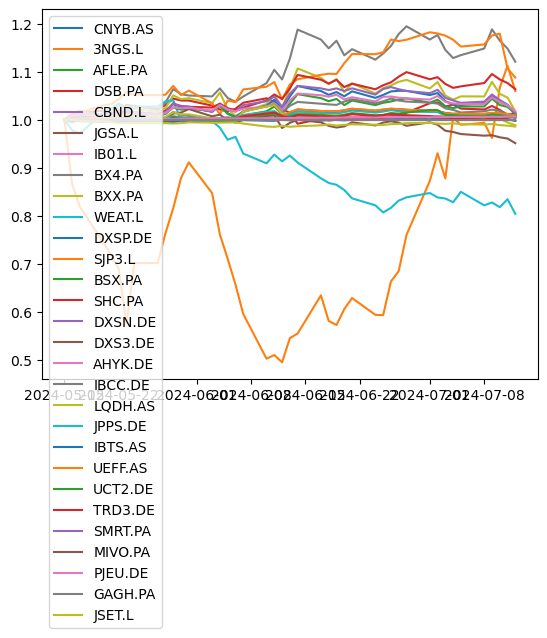

In [27]:
(df_quotes.loc[first_date:]/df_quotes.loc[first_date])[df['symbol']].plot()